In this notebook we explore the questions "Why do certain kernels behave the way they do (and why do PCA / no-PCA change that)?"

To answer this question in a structured way we devide the analysis in 2 parts - first for the global kernels and second for the local kernels.

Linear & Polynomial kernels:

- Look at: global structure, block patterns, effect of PCA on structure, eigenvalue spectrum (rank, decay); ingore locality (they dont have it)
- Questions to answer: Does PCA make the Gram matrix more structured? Does polynomial introduce higher-rank structure? Why does linear perform poorly (or not)?

RBF & Laplacian kernels:
- look at: locality (diagonal dominance), smoothness vs sharp decay, effect of γ, PCA’s impact on neighborhood structure
- Questions to answer: How tight are neighborhoods? Does Laplacian decay more sharply than RBF? Does PCA improve or hurt locality? Why does one outperform the other?

To diagnose kernels we will use the following tools:
-  Gram (kernel) matrix: The Gram matrix stores how similar every data point is to every other data point under a given kernel, so it fully describes how the kernel “sees” the dataset.
- Gram matrix visualization (heatmap): Plotting the Gram matrix lets us visually inspect whether the kernel encodes global similarity, local neighborhoods, or structured blocks, which helps explain why certain kernels perform better.
- Eigenvalue spectrum of the Gram matrix: the eigenvalues show how complex or expressive the kernel is, with faster decay indicating a simpler, lower-rank structure and slower decay indicating higher flexibility (and potentially higher variance).
- Eigenvalue spectrum plot: Plotting the eigenvalues helps us compare kernels and representations by showing how much effective dimensionality or noise each kernel introduces.
- Locality (diagonal dominance) score: The locality score measures how much a kernel focuses on nearby points by comparing diagonal values to off-diagonal values, which is especially important for understanding RBF and Laplacian kernels.
-Effect of PCA: PCA can change kernel behavior by removing noise and redundant directions, often leading to cleaner Gram matrices and more stable eigenvalue spectra, though its benefit depends on the kernel type.

In [1]:

import os
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.append(str(PROJECT_ROOT))

import pandas as pd
import numpy as np
from src.config import SEED
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve().parents[0]
if (PROJECT_ROOT / "src").exists():
    sys.path.insert(0, str(PROJECT_ROOT))

# Paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"


In [2]:
krr_results = pd.read_csv(RESULTS_DIR / "tables" / "krr_results.csv")
lr_results  = pd.read_csv(RESULTS_DIR / "tables" / "lr_results.csv")


In [3]:
X_scaled = np.load(DATA_DIR / "X_scaled.npy")
X_pca = np.load(DATA_DIR / "X_pca.npy")


In [4]:
diag_subsample_size = 800  # chosen to balance cost and structure

rng = np.random.default_rng(SEED)
diag_idx = rng.choice(len(X_scaled), size=diag_subsample_size, replace=False)

X_scaled_diag = X_scaled[diag_idx]
X_pca_diag = X_pca[diag_idx]

print("Diagnostic subsample shapes:")
print("X_scaled_diag:", X_scaled_diag.shape)
print("X_pca_diag   :", X_pca_diag.shape)

Diagnostic subsample shapes:
X_scaled_diag: (800, 81)
X_pca_diag   : (800, 17)


In [5]:
# create result table to store results
row_names = ["Linear Kernel", "Polynomial Kernel", "RBF Kernel", "Laplacian Kernel"]
col_names = ["Effective Rank - Scaled", "Effective Rank - PCA",
             "Locality Score - Scaled", "Locality Score - PCA",
             "Frobenius Norm - Scaled", "Frobenius Norm - PCA"]
results = pd.DataFrame(index=row_names, columns=col_names, dtype=float)

In [6]:

def get_best_params(results_df, model, kernel, representation):
    row = results_df[
        (results_df["model"] == model) &
        (results_df["kernel"] == kernel) &
        (results_df["representation"] == representation)
    ]

    if row.empty:
        raise ValueError(
            f"No results for model={model}, kernel={kernel}, "
            f"representation={representation}"
        )

    row = row.iloc[0]

    params = {}
    for key in ["best_gamma", "best_degree", "best_coef0", "best_lambda"]:
        if key in row and row[key] != "N/A" and not pd.isna(row[key]):
            params[key.replace("best_", "")] = float(row[key])

    return params


def compute_gram(kernel_obj, X):
    return kernel_obj(X, X)


def plot_gram_matrix(K, title):
    # plot a Gram matrix as a heatmap.
    plt.figure(figsize=(5, 5))
    plt.imshow(K, cmap="viridis", aspect="auto")
    plt.colorbar(label="Kernel value")
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Sample index")
    plt.tight_layout()
    plt.show()


def eigen_spectrum(K):
    eigvals = np.linalg.eigvalsh(K)
    return np.sort(eigvals)[::-1]


def plot_eigen_spectrum(eigvals, title, log_scale=True):
    plt.figure(figsize=(5, 4))
    if log_scale:
        plt.semilogy(eigvals)
    else:
        plt.plot(eigvals)

    plt.xlabel("Eigenvalue index")
    plt.ylabel("Eigenvalue magnitude")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def locality_score(K):
    diag = np.diag(K)
    row_sums = np.sum(K, axis=1)
    return float(np.mean(diag / (row_sums + 1e-12)))

def frobenius_norm(K):
    norm = np.linalg.norm(K, 'fro')
    return int(norm)

# Section 2. Diagnostics: Global kernels (Linear, Polynomial)
We use the best hyperparameters obtained from Kernel Ridge Regression results, as Gram matrix structure is most directly tied to KRR. (important to be mentioned and reasoned about in report)


Linear kernel — SCALED


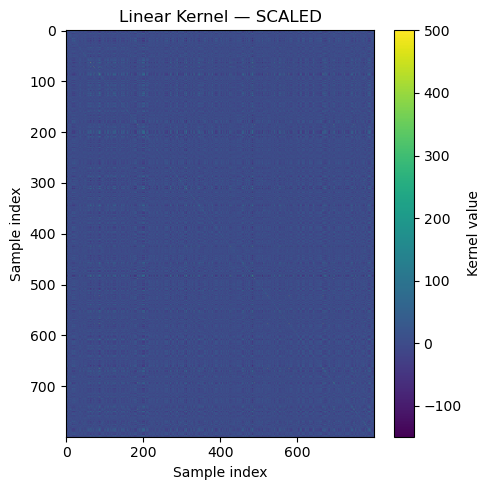

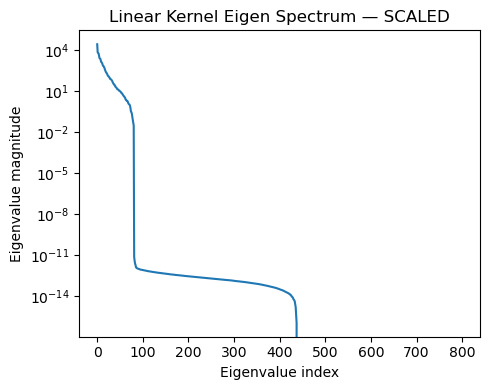

Effective rank (λ > 1e-6): 81

Linear kernel — PCA


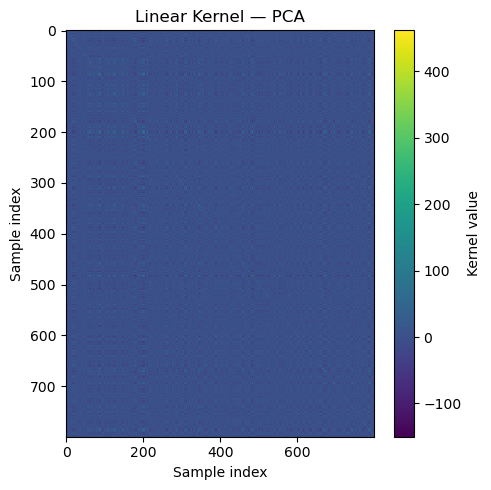

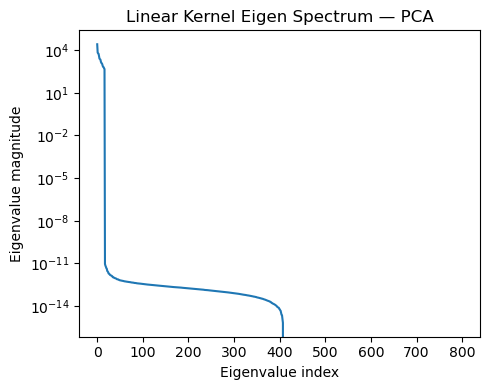

Effective rank (λ > 1e-6): 17


In [7]:

from src.kernels.linear import LinearKernel

MODEL_FOR_DIAGNOSTICS = "kernel_ridge_regression"
KERNEL_NAME = "linear"

for representation, X_diag in [
    ("scaled", X_scaled_diag),
    ("pca", X_pca_diag),
]:
    print(f"\nLinear kernel — {representation.upper()}")
    linear_kernel = LinearKernel()

    K = compute_gram(linear_kernel, X_diag)

    plot_gram_matrix(
        K,
        title=f"Linear Kernel — {representation.upper()}"
    )
    

    # Eigenvalue spectrum
    eigvals = eigen_spectrum(K)
    plot_eigen_spectrum(
        eigvals,
        title=f"Linear Kernel Eigen Spectrum — {representation.upper()}"
    )

    # Simple diagnostics
    effective_rank = np.sum(eigvals > 1e-6)
    print(f"Effective rank (λ > 1e-6): {effective_rank}")

    # add results to table
    results.loc["Linear Kernel", "Effective Rank - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = effective_rank
    results.loc["Linear Kernel", "Locality Score - " 
                + (representation.capitalize() if representation == "scaled" else "PCA")] = locality_score(K)
    results.loc["Linear Kernel", "Frobenius Norm - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = frobenius_norm(K)


polynomial kernel — SCALED


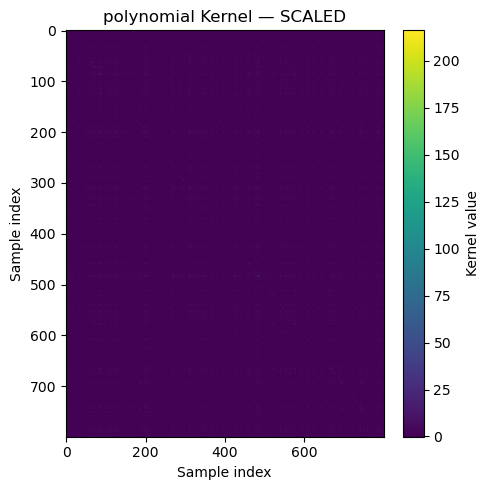

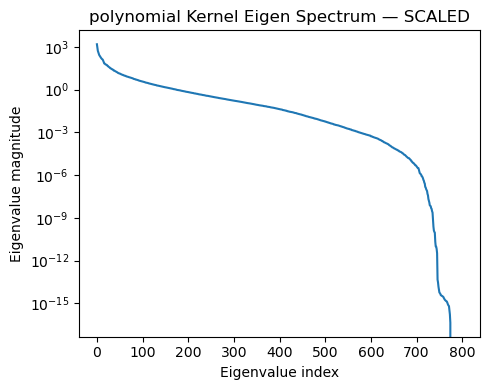

Effective rank (λ > 1e-6): 711

polynomial kernel — PCA


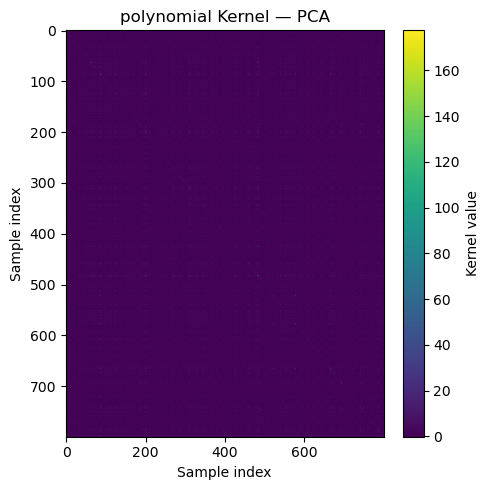

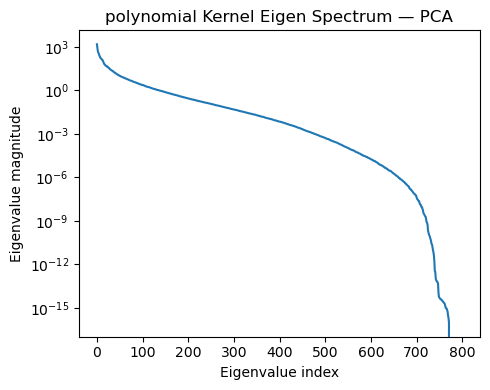

Effective rank (λ > 1e-6): 661


In [8]:

from src.kernels.polynomial import PolynomialKernel

MODEL_FOR_DIAGNOSTICS = "kernel_ridge_regression"
KERNEL_NAME = "linear"

for representation, X_diag in [
    ("scaled", X_scaled_diag),
    ("pca", X_pca_diag),
]:
    print(f"\npolynomial kernel — {representation.upper()}")
    polynomial_kernel = PolynomialKernel(3, 0.01, 1.0)

    K = compute_gram(polynomial_kernel, X_diag)

    plot_gram_matrix(
        K,
        title=f"polynomial Kernel — {representation.upper()}"
    )

    # Eigenvalue spectrum
    eigvals = eigen_spectrum(K)
    plot_eigen_spectrum(
        eigvals,
        title=f"polynomial Kernel Eigen Spectrum — {representation.upper()}"
    )

    # Simple diagnostics
    effective_rank = np.sum(eigvals > 1e-6)
    print(f"Effective rank (λ > 1e-6): {effective_rank}")

    # add results to table
    results.loc["Polynomial Kernel", "Effective Rank - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = effective_rank
    results.loc["Polynomial Kernel", "Locality Score - " 
                + (representation.capitalize() if representation == "scaled" else "PCA")] = locality_score(K)
    results.loc["Polynomial Kernel", "Frobenius Norm - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = frobenius_norm(K)

## For linear kernel

For the scaled linear kernel, the eigenvalues decrease slowly (visible as a long, shallow curve that stays above 1e-6 across many indices), resulting in a high effective rank of 81. This indicates that the kernel relies on many weak, noisy directions, which aligns with weaker performance (test RMSE/MAE ≈ 15.31 / 11.11 for local regression).

After applying PCA, the spectrum drops sharply (most eigenvalues fall below 1e-6 within the first ~20 indices), reducing the effective rank to 17. This means the kernel operates in far fewer effective dimensions and yields improved performance (test RMSE/MAE ≈ 13.99 / 8.95 for local regression).

Both linear-kernel Gram matrices look almost identical before and after PCA, showing a dense and uniform structure with no clear diagonal dominance or block patterns. I think this is expected because PCA is an orthogonal linear transformation, and the linear kernel depends only on dot products, which dot products are fully preserved under such transformations. As a result, PCA does not meaningfully change pairwise similarities for the linear kernel, explaining why the Gram matrix values and overall structure remain nearly unchanged.

## For polynomial kernel
To-do anlaysis (PCA seems to matter less - why?)

# Section 3. Diagnostics: Local kernels (RBF, Laplacian)


RBF kernel — SCALED


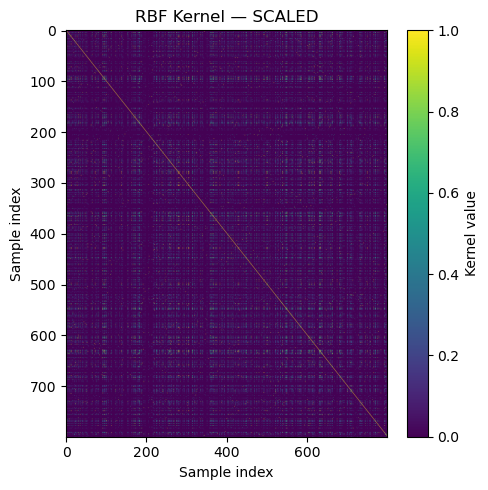

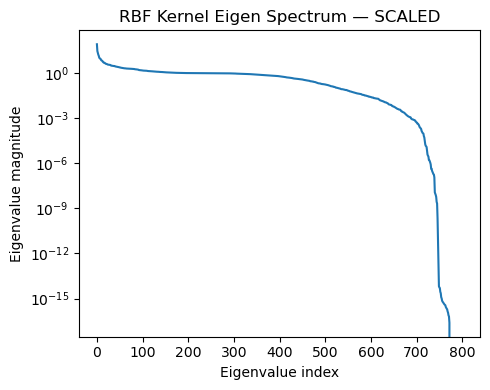

Effective rank (λ > 1e-6): 731

RBF kernel — PCA


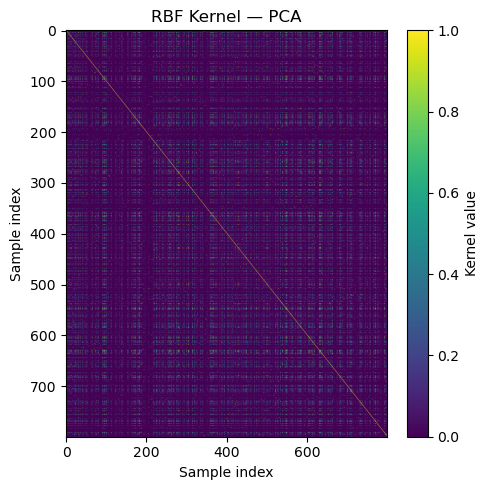

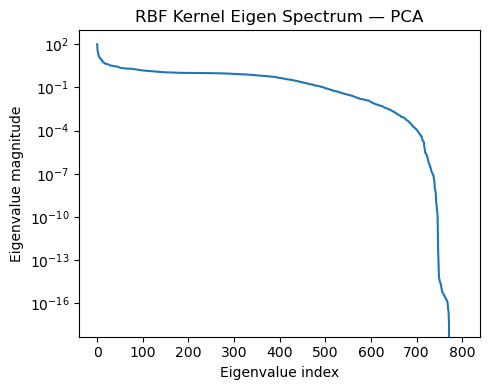

Effective rank (λ > 1e-6): 725


In [9]:
from src.kernels.rbf import RBFKernel

MODEL_FOR_DIAGNOSTICS = "kernel_ridge_regression"
KERNEL_NAME = "rbf"

# Best gamma value is equal for scaled and pca representations
rbf_params_scaled = get_best_params(krr_results, MODEL_FOR_DIAGNOSTICS, KERNEL_NAME, "scaled")

for representation, X_diag in [
    ("scaled", X_scaled_diag),
    ("pca", X_pca_diag),
]:
    print(f"\nRBF kernel — {representation.upper()}")
    rbf_kernel = RBFKernel(rbf_params_scaled["gamma"])

    K = compute_gram(rbf_kernel, X_diag)

    plot_gram_matrix(
        K,
        title=f"RBF Kernel — {representation.upper()}"
    )

    # Eigenvalue spectrum
    eigvals = eigen_spectrum(K)
    plot_eigen_spectrum(
        eigvals,
        title=f"RBF Kernel Eigen Spectrum — {representation.upper()}"
    )

    # Simple diagnostics
    effective_rank = np.sum(eigvals > 1e-6)
    print(f"Effective rank (λ > 1e-6): {effective_rank}")

    # add results to table
    results.loc["RBF Kernel", "Effective Rank - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = effective_rank
    results.loc["RBF Kernel", "Locality Score - " 
                + (representation.capitalize() if representation == "scaled" else "PCA")] = locality_score(K)
    results.loc["RBF Kernel", "Frobenius Norm - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = frobenius_norm(K)


Laplacian kernel — SCALED


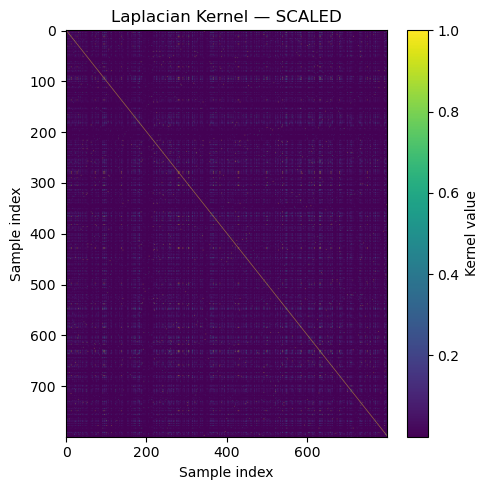

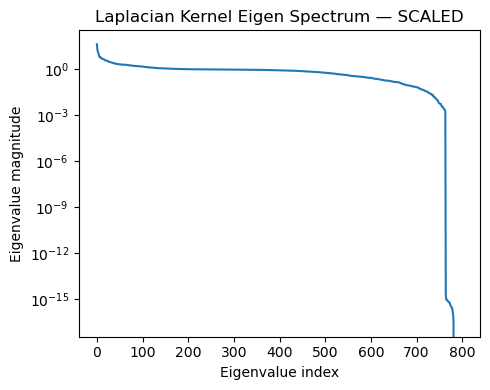

Effective rank (λ > 1e-6): 764

Laplacian kernel — PCA


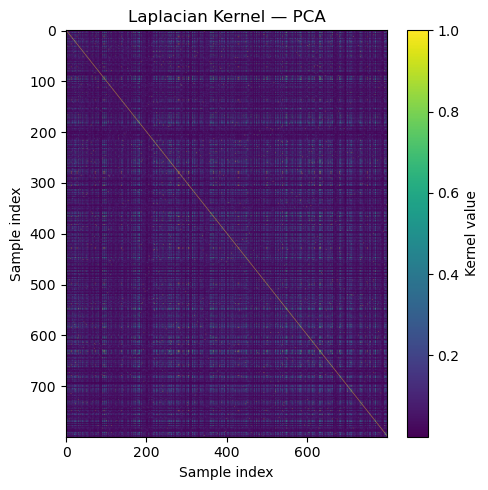

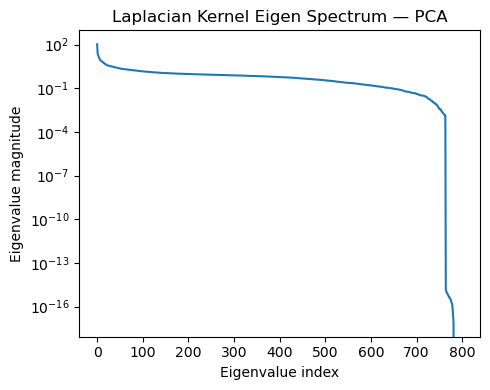

Effective rank (λ > 1e-6): 764


In [10]:
from src.kernels.laplacian import LaplacianKernel

MODEL_FOR_DIAGNOSTICS = "kernel_ridge_regression"
KERNEL_NAME = "laplacian"

# Best gamma value is equal for scaled and pca representations
laplacian_params_scaled = get_best_params(krr_results, MODEL_FOR_DIAGNOSTICS, KERNEL_NAME, "scaled")

for representation, X_diag in [
    ("scaled", X_scaled_diag),
    ("pca", X_pca_diag),
]:
    print(f"\nLaplacian kernel — {representation.upper()}")
    laplacian_kernel = LaplacianKernel(laplacian_params_scaled["gamma"])

    K = compute_gram(laplacian_kernel, X_diag)
    plot_gram_matrix(
        K,
        title=f"Laplacian Kernel — {representation.upper()}"
    )

    # Eigenvalue spectrum
    eigvals = eigen_spectrum(K)
    plot_eigen_spectrum(
        eigvals,
        title=f"Laplacian Kernel Eigen Spectrum — {representation.upper()}"
    )

    # Simple diagnostics
    effective_rank = np.sum(eigvals > 1e-6)
    print(f"Effective rank (λ > 1e-6): {effective_rank}")

    # add results to table
    results.loc["Laplacian Kernel", "Effective Rank - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = effective_rank
    results.loc["Laplacian Kernel", "Locality Score - " 
                + (representation.capitalize() if representation == "scaled" else "PCA")] = locality_score(K)
    results.loc["Laplacian Kernel", "Frobenius Norm - "
                + (representation.capitalize() if representation == "scaled" else "PCA")] = frobenius_norm(K)

# Section 4. Summary table
The table compares the effective rank for the different models across different scales. A high effective rank means that the variance is explained across many dimensions/features. Locality score measures how much it focuses on nearby points.

It also includes the frobenius norm of the Gram matrix which measures the similarity of the values in the kernel. If Frobenius norm drops significantly after PCA, it means the kernel sees points as more dissimilar in PCA space, potentially explaining performance differences. PCA changes the data scale/dimensionality, which affects total similarity magnitude

In [11]:
results.to_csv(TABLES_DIR / "kernel_diagnostics.csv", index=False)
results

,Effective Rank - Scaled,Effective Rank - PCA,Locality Score - Scaled,Locality Score - PCA,Frobenius Norm - Scaled,Frobenius Norm - PCA
Linear Kernel,81.0,17.0,-0.022341,0.002581,28287.0,28262.0
Polynomial Kernel,711.0,661.0,0.006380,0.005944,2007.0,1979.0
RBF Kernel,731.0,725.0,0.301764,0.260245,101.0,117.0
Laplacian Kernel,764.0,764.0,0.304027,0.032013,63.0,116.0
